In [2]:
import elfi
import numpy as np
import pylab as plt
import scipy.stats as ss
import os
import sys
import pickle
sys.path.append(os.path.abspath(os.path.join('../..')))
import pyabc
from pyabc.plots import plot_marginals, plot_particles
%matplotlib notebook

# The problem

We begin with a very intuitive and easy toy example that will allow us to analytically compute the posterior. Our model will be $x \sim \mathcal{N}(\mu,\sigma^2)$, that is $x$ is distributed according to a Gaussian normal distribution with mean $\mu$ and variance $\sigma^2$. Let us assume that we have observed data $D=\{x_i|i=1,\ldots,30\}$ for which we know the variance $\sigma^2=1$ (for example from previous experiments or from literature)

# Generative Model

For the purpose of different priors, we assume that our generative model has the following shape: $g: x \sim \mathcal{N}(0.5, 1)$

In [3]:
np.random.seed(1335)

In [4]:
mu_t, sigma_t = 0.5, 1
mu_0, sigma_0 = 0, 0.2

N = 10

In [5]:
D = np.random.normal(mu_t, np.sqrt(sigma_t), N)
#os.makedirs(os.path.basename(os.path.join("data", "D")), exist_ok=True)
#pickle.dump(D, open(os.path.join("data", "D.pkl"), "wb"))
np.atleast_2d(D)

array([[-0.55286363,  0.73839318, -0.05872936,  2.57544769,  0.33974323,
        -0.7431614 , -1.14733082, -0.39151276,  0.7952032 ,  0.48591288]])

<IPython.core.display.Javascript object>


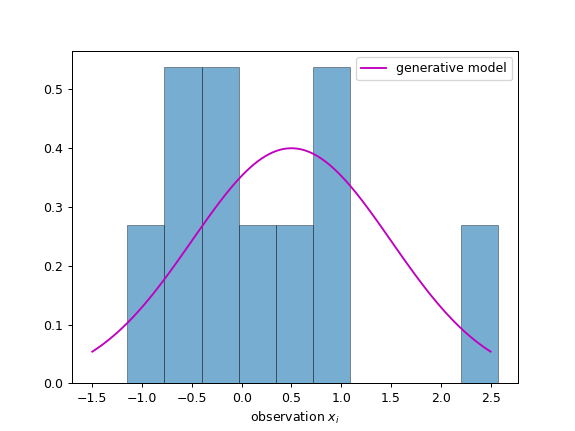

Text(0.5,0,'observation $x_i$')

In [6]:
plt.figure()
plt.hist(D, edgecolor="k", linewidth=0.5, color=["C0"], normed=True, alpha=0.6, histtype="bar", bins=N)
x = np.linspace(0.5-2, 0.5+2, 100)
y = ss.norm.pdf(x, mu_t, np.sqrt(sigma_t))
plt.plot(x,y, "-", color="m", label="generative model")
plt.legend()
plt.xlabel("observation $x_i$")

# Prior and Likelihood

We are interested in the probability distribution of the model parameter $\theta=\mu$ given our observed data, thus with Bayes' Theorem we can write

$p(\theta|D) \propto p(D|\theta) \cdot p(\theta).$

With the assumption of indentically and independently distributed (i.i.d.) drawn samples, the likelihood $p(D|\theta)$ can be written as the product of the likelihoods for each datum: $p(D|\theta) = \prod_{i=1}^N p(x_i|\theta) = (\cfrac{1}{2\pi\sigma²})^{\frac{n}{2}} \exp \left( -\cfrac{\sum_i^n (x_i - \mu)^2}{2\sigma^2} \right)$.

The prior represents our initial belief about the values $\theta=\mu$ might take. We will analyse the following three priors that represent very different initial belief sets.

$p(\theta) = \mathcal{N}(\theta|\mu_0, \sigma_0)$, with $\mu_0 = 0, \sigma_0^2 = 0.2$

<IPython.core.display.Javascript object>


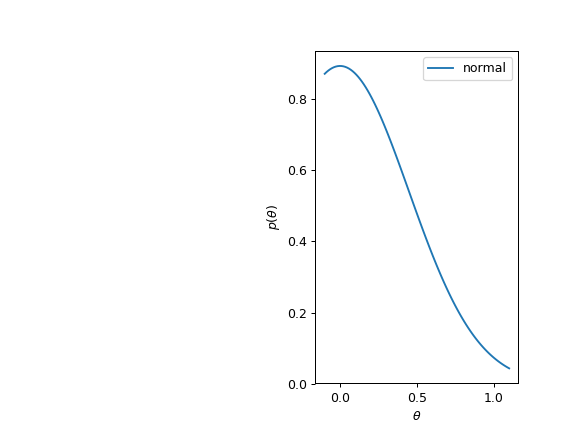

In [8]:
plt.figure()

# normal distributed prior
plt.subplot(1,2,2)
x = np.linspace(-0.1, 1.1, 100)
y = ss.norm.pdf(x, mu_0, np.sqrt(sigma_0))
plt.plot(x,y, label="normal")
plt.xlabel(r"$\theta$")
plt.ylabel(r"$p(\theta)$")
plt.legend(loc="upper right")

# Posterior

Now we look at the posterior. For each of the three priors, we can analytically calculate the posterior. Lets do this:

$\begin{align}
p(\theta=\mu|D) \propto p(D|\theta) \cdot p_2(\theta) &= \prod_{i=1}^N \mathcal{N}(\mu, \sigma^2) \cdot \mathcal{N}(\mu_0, \sigma^2_0) = \mathcal{N}(\mu_N, \sigma^2_N), \mu_N = \cfrac{1}{N\sigma_0^2 + \sigma^2} \cdot (\sigma^2\mu_0 + N\sigma_0^2\mu), \sigma^2_N = \cfrac{\sigma^2\sigma^2_0}{N\sigma^2_0 + \sigma^2} \\
\end{align}
$

In [6]:
def likelihood(mus):
    ret = np.zeros(mus.shape[0])
    for i, mu in enumerate(mus):
        ret[i] = ss.norm(mu, sigma_t / N).pdf(np.mean(D))
    return ret

def posterior(mus):
    sigma_N = 1 / (N/sigma_t + 1/sigma_0)
    mu_N = sigma_N * (mu_0 / sigma_0 + N * np.mean(D) / sigma_t)
    
    ret = np.zeros(mus.shape[0])
    for i, mu in enumerate(mus):
        ret[i] = ss.norm(mu_N, np.sqrt(sigma_N)).pdf(mu)
    return ret

In [11]:
# These are the "Tableau 20" colors as RGB.    
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)] 


# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
for i in range(len(tableau20)):    
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.)  

<IPython.core.display.Javascript object>


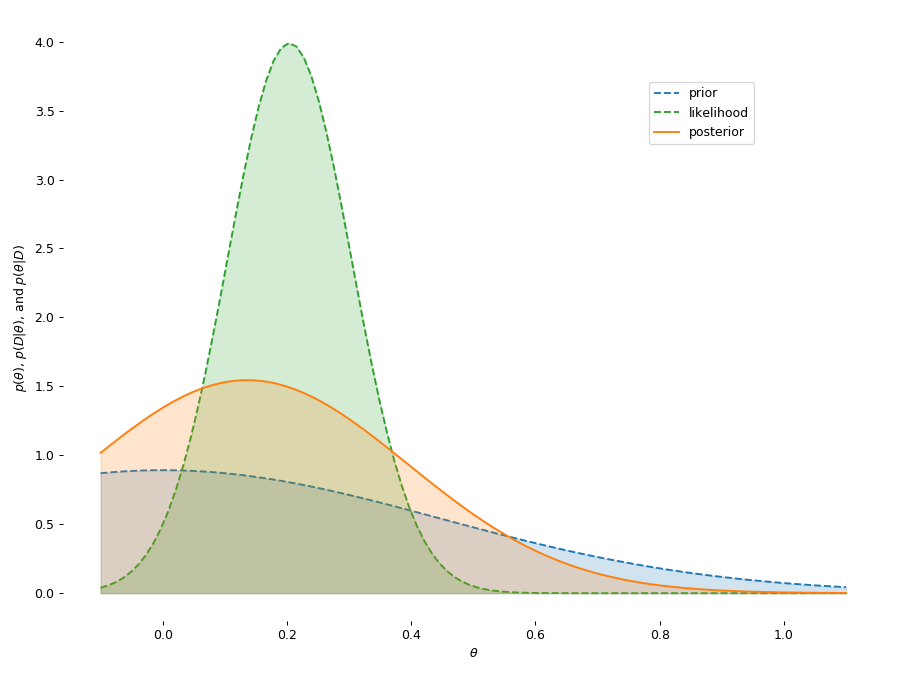

In [28]:
# You typically want your plot to be ~1.33x wider than tall. This plot is a rare    
# exception because of the number of lines being plotted on it.    
# Common sizes: (10, 7.5) and (12, 9)    
plt.figure(figsize=(10, 7.5)) 

# Remove the plot frame lines. They are unnecessary chartjunk.    
ax = plt.subplot(111)    
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False)  
# Ensure that the axis ticks only show up on the bottom and left of the plot.    
# Ticks on the right and top of the plot are generally unnecessary chartjunk.    
ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left()   

# Make sure your axis ticks are large enough to be easily read.    
# You don't want your viewers squinting to read your plot.    
#plt.yticks(np.arange(0, 4.5, 0.5), [str(x) for x in np.arange(0, 4.5, 0.5)])    
#plt.xticks(fontsize=12) 

thetas = np.linspace(-0.1, 1.1, 100)
prior = ss.norm.pdf(thetas, mu_0, np.sqrt(sigma_0))
ax.fill_between(thetas, y1=y, y2=0, alpha=0.2, zorder=0, color=tableau20[0])
ax.plot(thetas,y, "--", label="prior",  color=tableau20[0], zorder=0)

#ax2 = ax.twinx()
like = likelihood(thetas)
ax.fill_between(thetas, y1=like, y2=0, alpha=0.2,  color=tableau20[4], zorder=1)
ax.plot(thetas, like, "--", label="likelihood",  color=tableau20[4], zorder=1)

ax.fill_between(thetas, y1=posterior(thetas), y2=0, alpha=0.2,  color=tableau20[2], zorder=30)
ax.plot(thetas, posterior(thetas), label="posterior",  color=tableau20[2], zorder=30)

plt.xlabel(r"$\theta$")
ax.set_ylabel(r"$p(\theta)$, $p(D|\theta)$, and $p(\theta|D)$")

plt.legend(bbox_to_anchor=(0.85, 0.9))
plt.tight_layout()

plt.savefig('ex01_model.pdf', bbox_inches='tight')

# ABC

In [29]:
prior = pyabc.Prior("normal", mu_0, np.sqrt(sigma_0), name=r"$\mu$")

In [30]:
def simulator_mu(mu, batch_size=1, random_state=None):
    return ss.norm(loc=mu, scale=np.sqrt(sigma_t)).rvs((batch_size, N))

simulator_mu(0)

array([[-1.36402709, -0.79474783, -1.07291723,  0.21274463, -0.58600603,
        -0.97971222,  1.18346127,  0.22661906,  0.48866767, -0.03059361]])

In [31]:
def mean(x):
    return np.mean(np.atleast_2d(x), axis=1)

## Show correctness for three classical ABC sampler

In [32]:
D = np.atleast_2d(D)
rej = pyabc.RejectionSampler(priors=prior, simulator=simulator_mu, summaries=[mean], observation=D, verbosity=2)
mcmc = pyabc.MCMCSampler(priors=prior, simulator=simulator_mu, summaries=[mean], observation=D, verbosity=2)
smc = pyabc.SMCSampler(priors=prior, simulator=simulator_mu, summaries=[mean], observation=D, verbosity=2)

In [ ]:
# or load data
path_to_data = "/home/michael/Dropbox/AppliedCognitiveModelling2017/ABC/03 data/"
rej = pyabc.RejectionSampler(os.path.join(path_to_data, "ex01", "rej_2000_0_02.pkl"))
mcmc = pyabc.RejectionSampler(os.path.join(path_to_data, "ex01", "mcmc_2000_0_02_0_1.pkl"))

In [33]:
rej.sample(nr_samples=2000, threshold=0.02)

Rejection sampler started with threshold: 0.02 and number of samples: 2000
Samples:     29 /   2000 (  1 %)- Threshold: 0.0200 - Iterations:       1000 - Acceptance rate: 0.029000 - Time:     0.76 s
Samples:     55 /   2000 (  3 %)- Threshold: 0.0200 - Iterations:       2000 - Acceptance rate: 0.027500 - Time:     1.46 s
Samples:     88 /   2000 (  4 %)- Threshold: 0.0200 - Iterations:       3000 - Acceptance rate: 0.029333 - Time:     2.14 s
Samples:    119 /   2000 (  6 %)- Threshold: 0.0200 - Iterations:       4000 - Acceptance rate: 0.029750 - Time:     2.82 s
Samples:    148 /   2000 (  7 %)- Threshold: 0.0200 - Iterations:       5000 - Acceptance rate: 0.029600 - Time:     3.54 s
Samples:    173 /   2000 (  9 %)- Threshold: 0.0200 - Iterations:       6000 - Acceptance rate: 0.028833 - Time:     4.22 s
Samples:    198 /   2000 ( 10 %)- Threshold: 0.0200 - Iterations:       7000 - Acceptance rate: 0.028286 - Time:     4.90 s
Samples:    229 /   2000 ( 11 %)- Threshold: 0.0200 - Ite

Samples:   1841 /   2000 ( 92 %)- Threshold: 0.0200 - Iterations:      67000 - Acceptance rate: 0.027478 - Time:    49.76 s
Samples:   1871 /   2000 ( 94 %)- Threshold: 0.0200 - Iterations:      68000 - Acceptance rate: 0.027515 - Time:    50.55 s
Samples:   1895 /   2000 ( 95 %)- Threshold: 0.0200 - Iterations:      69000 - Acceptance rate: 0.027464 - Time:    51.28 s
Samples:   1916 /   2000 ( 96 %)- Threshold: 0.0200 - Iterations:      70000 - Acceptance rate: 0.027371 - Time:    52.03 s
Samples:   1949 /   2000 ( 97 %)- Threshold: 0.0200 - Iterations:      71000 - Acceptance rate: 0.027451 - Time:    52.72 s
Samples:   1977 /   2000 ( 99 %)- Threshold: 0.0200 - Iterations:      72000 - Acceptance rate: 0.027458 - Time:    53.40 s
Samples:   1999 /   2000 (100 %)- Threshold: 0.0200 - Iterations:      73000 - Acceptance rate: 0.027384 - Time:    54.07 s
Samples:   2033 /   2000 (102 %)- Threshold: 0.0200 - Iterations:      74000 - Acceptance rate: 0.027473 - Time:    54.73 s
Samples:

In [35]:
path_to_data = "/home/michael/Dropbox/AppliedCognitiveModelling2017/ABC/03 data/"
rej.save(os.path.join(path_to_data, "ex01", "rej_2000_0_02.pkl"))

In [36]:
mcmc.sample(nr_samples=2000, threshold=0.02, step_size=[0.1])

MCMC sampler started with threshold: 0.02 and number of samples: 2000
Samples:     10 - Threshold: 0.0200 - Iterations:        180 - Acceptance rate: 0.055556 - Time:     0.21 s
Samples:     46 /   2000 (  2 %)- Threshold: 0.0200 - Iterations:       1000 - Acceptance rate: 2.000000 - Time:     1.20 s
Samples:     64 /   2000 (  3 %)- Threshold: 0.0200 - Iterations:       2000 - Acceptance rate: 1.000000 - Time:     2.15 s
Samples:     89 /   2000 (  4 %)- Threshold: 0.0200 - Iterations:       3000 - Acceptance rate: 0.666667 - Time:     3.10 s
Samples:    119 /   2000 (  6 %)- Threshold: 0.0200 - Iterations:       4000 - Acceptance rate: 0.500000 - Time:     4.06 s
Samples:    149 /   2000 (  7 %)- Threshold: 0.0200 - Iterations:       5000 - Acceptance rate: 0.400000 - Time:     5.04 s
Samples:    174 /   2000 (  9 %)- Threshold: 0.0200 - Iterations:       6000 - Acceptance rate: 0.333333 - Time:     6.04 s
Samples:    208 /   2000 ( 10 %)- Threshold: 0.0200 - Iterations:       7000 -

In [37]:
path_to_data = "/home/michael/Dropbox/AppliedCognitiveModelling2017/ABC/03 data/"
mcmc.save(os.path.join(path_to_data, "ex01", "mcmc_2000_0_02_0_1.pkl"))

In [38]:
smc.sample(nr_samples=2000, thresholds=np.linspace(0.1, 0.02, 6))

SMC sampler started with thresholds: [ 0.1    0.084  0.068  0.052  0.036  0.02 ] and number of samples: 2000
Rejection sampler started with threshold: 0.1 and number of samples: 2000
Samples:    107 /   2000 (  5 %)- Threshold: 0.1000 - Iterations:       1000 - Acceptance rate: 0.107000 - Time:     0.78 s
Samples:    240 /   2000 ( 12 %)- Threshold: 0.1000 - Iterations:       2000 - Acceptance rate: 0.120000 - Time:     1.48 s
Samples:    375 /   2000 ( 19 %)- Threshold: 0.1000 - Iterations:       3000 - Acceptance rate: 0.125000 - Time:     2.21 s
Samples:    532 /   2000 ( 27 %)- Threshold: 0.1000 - Iterations:       4000 - Acceptance rate: 0.133000 - Time:     3.03 s
Samples:    661 /   2000 ( 33 %)- Threshold: 0.1000 - Iterations:       5000 - Acceptance rate: 0.132200 - Time:     3.79 s
Samples:    802 /   2000 ( 40 %)- Threshold: 0.1000 - Iterations:       6000 - Acceptance rate: 0.133667 - Time:     4.57 s
Samples:    922 /   2000 ( 46 %)- Threshold: 0.1000 - Iterations:       7

KeyboardInterrupt: 

In [39]:
np.linspace(0.1, 0.02, 6)

array([ 0.1  ,  0.084,  0.068,  0.052,  0.036,  0.02 ])

In [16]:
path_to_data = "/home/michael/Dropbox/AppliedCognitiveModelling2017/ABC/03 data/"
smc.save(os.path.join(path_to_data, "ex01", "smc_2000_0_1_to_0_02.pkl"))

<IPython.core.display.Javascript object>


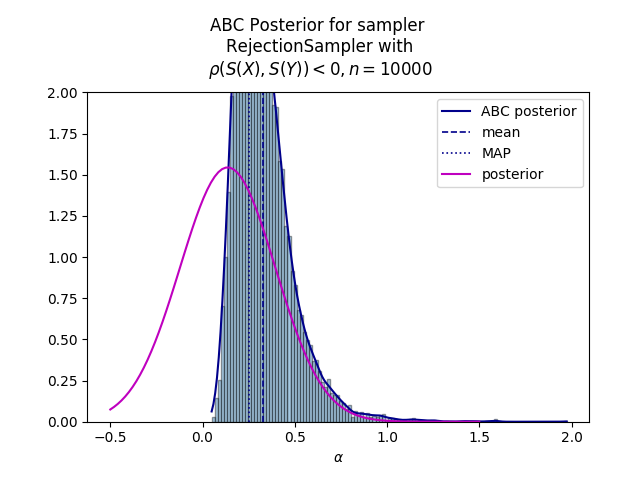

<IPython.core.display.Javascript object>


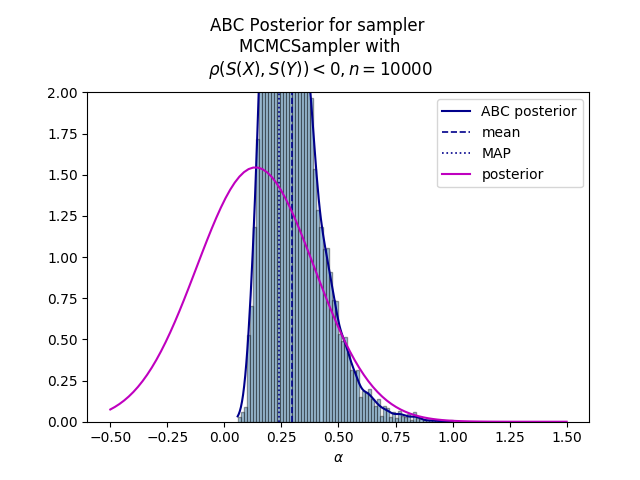

<IPython.core.display.Javascript object>


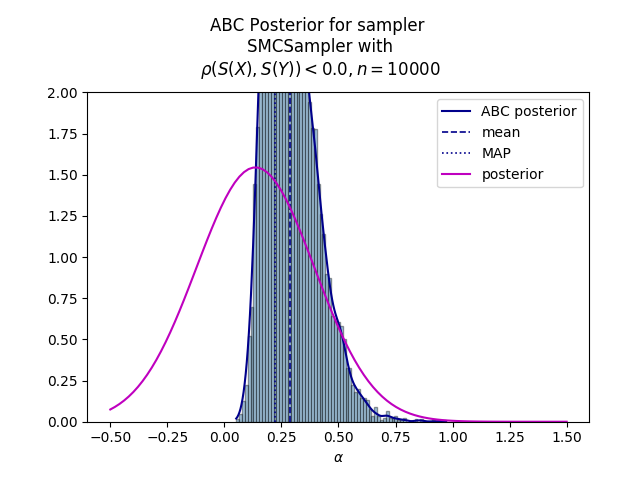

In [20]:
fig = plot_marginals(rej, hist_kws = {'normed': True}, ylim=[0, 2])
x = np.linspace(mu_t-1, mu_t+1, 100)

prior = ss.norm.pdf(x, mu_0, np.sqrt(sigma_0))
like = likelihood(x)

plt.plot(x, posterior(x), "m", label="posterior")
plt.legend()

plt.savefig('ex01_rej_n_2000_e_0_02_D_10.pdf', bbox_inches='tight')

fig = plot_marginals(mcmc, hist_kws = {'normed': True}, ylim=[0, 2])

plt.plot(x, posterior(x), "m", label="posterior")
plt.legend()

plt.savefig('ex01_mcmc_n_2000_e_0_02_s_0_05_D_10.pdf', bbox_inches='tight')

fig = plot_marginals(smc, hist_kws = {'normed': True}, ylim=[0, 2])

plt.plot(x, posterior(x), "m", label="posterior")
plt.legend()

plt.savefig('ex01_smc_n_2000_e_0_02_es_6_D_10.pdf', bbox_inches='tight')

# Comparison with ELFI

In [ ]:
mu = elfi.Prior('normal', mu_0, np.sqrt(sigma_0))

# Add the simulator node and observed data to the model
sim = elfi.Simulator(simulator_mu, mu, observed=np.atleast_2d(D))

# Add summary statistics to the model
S1 = elfi.Summary(mean, sim)

# Specify distance as euclidean between summary vectors (S1, S2) from simulated and
# observed data
d = elfi.Distance('euclidean', S1)

In [ ]:
# Plot the complete model (requires graphviz)
elfi.draw(d)

In [ ]:
elfi_smc = elfi.SMC(d, batch_size=1, seed=30052017)
elfi_smc = smc.sample(2000, np.linspace(0.1,0.03,4))

elfi_smc.summary()

In [ ]:
elfi_smc.plot_marginals()

## Analyze influence of parameter

### Influence of epsilon

Rejection sampler started with threshold: 1 and number of samples: 2000
Samples:    918 /   2000 ( 46 %)- Threshold: 1.0000 - Iterations:       1000 - Acceptance rate: 0.918000 - Time:     0.69 s
Samples:   1828 /   2000 ( 91 %)- Threshold: 1.0000 - Iterations:       2000 - Acceptance rate: 0.914000 - Time:     1.58 s
Samples:   2737 /   2000 (137 %)- Threshold: 1.0000 - Iterations:       3000 - Acceptance rate: 0.912333 - Time:     2.24 s
Samples:   2000 - Threshold: 1.0000 - Iterations:       3000 - Acceptance rate: 0.666667 - Time:     2.24 s


<IPython.core.display.Javascript object>


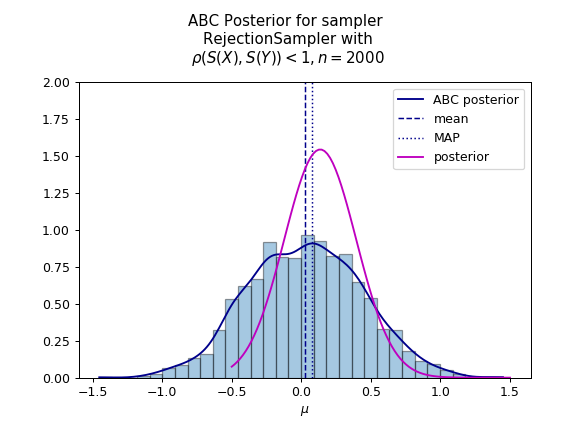

Rejection sampler started with threshold: 0.5 and number of samples: 2000
Samples:    610 /   2000 ( 30 %)- Threshold: 0.5000 - Iterations:       1000 - Acceptance rate: 0.610000 - Time:     0.69 s
Samples:   1196 /   2000 ( 60 %)- Threshold: 0.5000 - Iterations:       2000 - Acceptance rate: 0.598000 - Time:     1.37 s
Samples:   1815 /   2000 ( 91 %)- Threshold: 0.5000 - Iterations:       3000 - Acceptance rate: 0.605000 - Time:     2.13 s
Samples:   2409 /   2000 (120 %)- Threshold: 0.5000 - Iterations:       4000 - Acceptance rate: 0.602250 - Time:     3.15 s
Samples:   2000 - Threshold: 0.5000 - Iterations:       4000 - Acceptance rate: 0.500000 - Time:     3.15 s


<IPython.core.display.Javascript object>


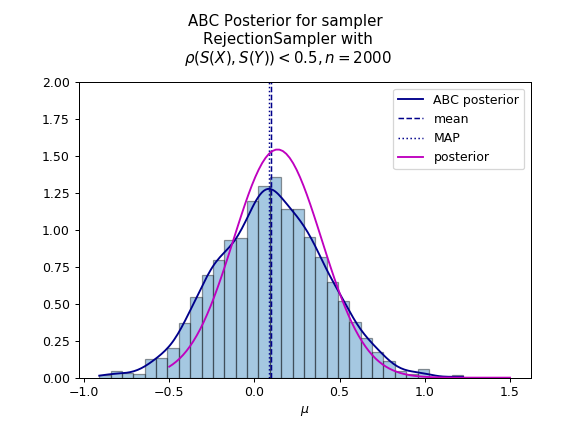

Rejection sampler started with threshold: 0.02 and number of samples: 2000
Samples:     31 /   2000 (  2 %)- Threshold: 0.0200 - Iterations:       1000 - Acceptance rate: 0.031000 - Time:     0.76 s
Samples:     50 /   2000 (  2 %)- Threshold: 0.0200 - Iterations:       2000 - Acceptance rate: 0.025000 - Time:     1.52 s
Samples:     80 /   2000 (  4 %)- Threshold: 0.0200 - Iterations:       3000 - Acceptance rate: 0.026667 - Time:     2.18 s
Samples:    101 /   2000 (  5 %)- Threshold: 0.0200 - Iterations:       4000 - Acceptance rate: 0.025250 - Time:     3.05 s
Samples:    129 /   2000 (  6 %)- Threshold: 0.0200 - Iterations:       5000 - Acceptance rate: 0.025800 - Time:     4.01 s
Samples:    164 /   2000 (  8 %)- Threshold: 0.0200 - Iterations:       6000 - Acceptance rate: 0.027333 - Time:     4.84 s
Samples:    189 /   2000 (  9 %)- Threshold: 0.0200 - Iterations:       7000 - Acceptance rate: 0.027000 - Time:     5.86 s
Samples:    214 /   2000 ( 11 %)- Threshold: 0.0200 - Ite

Samples:   1835 /   2000 ( 92 %)- Threshold: 0.0200 - Iterations:      67000 - Acceptance rate: 0.027388 - Time:    48.31 s
Samples:   1865 /   2000 ( 93 %)- Threshold: 0.0200 - Iterations:      68000 - Acceptance rate: 0.027426 - Time:    48.97 s
Samples:   1890 /   2000 ( 94 %)- Threshold: 0.0200 - Iterations:      69000 - Acceptance rate: 0.027391 - Time:    49.66 s
Samples:   1920 /   2000 ( 96 %)- Threshold: 0.0200 - Iterations:      70000 - Acceptance rate: 0.027429 - Time:    50.33 s
Samples:   1946 /   2000 ( 97 %)- Threshold: 0.0200 - Iterations:      71000 - Acceptance rate: 0.027408 - Time:    51.00 s
Samples:   1971 /   2000 ( 99 %)- Threshold: 0.0200 - Iterations:      72000 - Acceptance rate: 0.027375 - Time:    51.65 s
Samples:   1997 /   2000 (100 %)- Threshold: 0.0200 - Iterations:      73000 - Acceptance rate: 0.027356 - Time:    52.32 s
Samples:   2031 /   2000 (102 %)- Threshold: 0.0200 - Iterations:      74000 - Acceptance rate: 0.027446 - Time:    53.00 s
Samples:

<IPython.core.display.Javascript object>


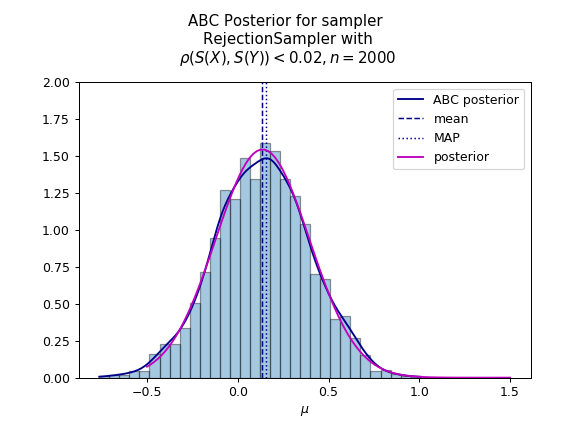

In [15]:
rej.sample(nr_samples=2000, threshold=1)

fig = plot_marginals(rej, hist_kws = {'normed': True}, ylim=[0, 2])
x = np.linspace(mu_t-1, mu_t+1, 100)
y = posterior(x)

plt.plot(x, y, "m", label="posterior")
plt.legend()

plt.savefig('ex01_rej_n_2000_e_1_D_10.pdf', bbox_inches='tight')

rej.sample(nr_samples=2000, threshold=0.5)

fig = plot_marginals(rej, hist_kws = {'normed': True}, ylim=[0, 2])

plt.plot(x, y, "m", label="posterior")
plt.legend()

plt.savefig('ex01_rej_n_2000_e_0_5_D_10.pdf', bbox_inches='tight')

rej.sample(nr_samples=2000, threshold=0.02)

fig = plot_marginals(rej, hist_kws = {'normed': True}, ylim=[0, 2])

plt.plot(x, y, "m", label="posterior")
plt.legend()

plt.savefig('ex01_rej_n_2000_e_0_02_D_10.pdf', bbox_inches='tight')


### Influence of samples

In [ ]:
rej.sample(nr_samples=100, threshold=0.02)

fig = plot_marginals(rej, hist_kws = {'normed': True})
x = np.linspace(mu_t-1, mu_t+1, 100)
y = posterior(x)

plt.plot(x, y, "m", label="posterior")
plt.legend()

plt.savefig('ex01_rej_n_100_e_0_02_D_10.pdf', bbox_inches='tight')


rej.sample(nr_samples=1000, threshold=0.02)

fig = plot_marginals(rej, hist_kws = {'normed': True})

plt.plot(x, y, "m", label="posterior")
plt.legend()

plt.savefig('ex01_rej_n_1000_e_0_02_D_10.pdf', bbox_inches='tight')

rej.sample(nr_samples=10000, threshold=0.02)

fig = plot_marginals(rej, hist_kws = {'normed': True})

plt.plot(x, y, "m", label="posterior")
plt.legend()

plt.savefig('ex01_rej_n_10000_e_0_02_D_10.pdf', bbox_inches='tight')


### Influence of amount of observational data

In [ ]:
N = 10
D = np.random.normal(mu_t, np.sqrt(sigma_t), N)
rej = pyabc.RejectionSampler(priors=prior, simulator=simulator_mu, summaries=[mean], observation=D)
rej.sample(nr_samples=2000, threshold=0.02)

fig = plot_marginals(rej, hist_kws = {'normed': True})

x = np.linspace(mu_t-1, mu_t+1, 100)
y = posterior(x)

plt.plot(x, y, "m", label="posterior")
plt.legend()

plt.savefig('ex01_rej_n_2000_e_0_02_D_10.pdf', bbox_inches='tight')

N = 50
D = np.random.normal(mu_t, np.sqrt(sigma_t), N)
rej = pyabc.RejectionSampler(priors=prior, simulator=simulator_mu, summaries=[mean], observation=D)
rej.sample(nr_samples=2000, threshold=0.02)

fig = plot_marginals(rej, hist_kws = {'normed': True})

x = np.linspace(mu_t-1, mu_t+1, 100)
y = posterior(x)

plt.plot(x, y, "m", label="posterior")
plt.legend()

plt.savefig('ex01_rej_n_2000_e_0_02_D_50.pdf', bbox_inches='tight')

N = 100
D = np.random.normal(mu_t, np.sqrt(sigma_t), N)
rej = pyabc.RejectionSampler(priors=prior, simulator=simulator_mu, summaries=[mean], observation=D)
rej.sample(nr_samples=2000, threshold=0.02)

fig = plot_marginals(rej, hist_kws = {'normed': True})

x = np.linspace(mu_t-1, mu_t+1, 100)
y = posterior(x)
plt.plot(x, y, "m", label="posterior")
plt.legend()

plt.savefig('ex01_rej_n_2000_e_0_02_D_100.pdf', bbox_inches='tight')